# Genetic Algorithm & Travelling Salesperson Problem

## Physics 3G03 Final Project

Alex Kappen

Student #: 400199797

30 April, 2021

## Introduction

In nature, we see incredibly diverse solutions to the problem of staying alive and reproducing; Birds, insects, dinosaurs, bacteria, fungi, archaea, plants, humans, and all kinds of creatures have existed and continue to exist thanks to the principle of evolution. Clearly, there are many successful solutions to staying alive. In computer science terms, we can say that the "solution space" of the problem is massive.

We find massive solution spaces in numerous other problems in science & technology, medicine, finance, and other fields. For example, what is the best antenna design for a spacecraft? Or, given all the available medicines, which combination should I take or avoid? These problems are especially difficult to solve because, as in nature, we don't know the best answer, and solutions need to adapt to the features and constraints of the current version of the problem.

Like nature, we can take advantage of the principle of evolution to navigate these massive, dynamic solution spaces in a direction that will lead us to optimal, or near-optimal, solutions in a reasonable amount of time and energy. Artifical Intelligence computer programs that operate with this principle are called "Evolutionary Algorithms". Tim Harford describes them nicely:

>“The evolutionary algorithm--of variation and selection, repeated--searches for solutions in a world where the problems keep changing, trying all sorts of variants and doing more of what works.” - Tim Harford, *Adapt: Why Success Always Starts with Failure*

Evolutionary Algorithms are a broad topic, so I will narrow down the focus of this project to a subclass called **Genetic Algorithms**. One problem in particular that I will explore is the **Travelling Salesperson Problem**.

In [41]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from time import sleep
from ipycanvas import Canvas, hold_canvas
from IPython.display import Image 

## The Travelling Salesperson Problem (TSP)

A travelling salesperson wishes to visit $n$ cities, but wants to visit the cities such that they minimize the overall distance of the trip. What order should the travelling salesperson visit the cities?

We can abstract this problem by saying: What is the shortest set of edges that connect a random set of points in 2D space?

In [50]:
def create_cities(total_cities, lower_bounds=[0, 0], upper_bounds=[100, 100]):
    return np.random.randint(lower_bounds, upper_bounds, size=(total_cities, 2))

# Visualize cities
canvas = Canvas(width=400, height=300, sync_image_data=True)
display(canvas)
print("What is the shortest path connecting all these points? (cities_7.png)")

cities7 = create_cities(7, lower_bounds=[15, 15], upper_bounds=[(canvas.width)-15, canvas.height-15])

with hold_canvas(canvas):
        # Draw cities & Paths
        canvas.line_width = 1.0
        canvas.fill_style = '#000000'
        canvas.fill_rect(0, 0, canvas.width, canvas.height)
        canvas.fill_style = '#ffffff'
        canvas.fill_circles(cities[:,0], cities[:,1], 3)

Canvas(height=300, sync_image_data=True, width=400)

What is the shortest path connecting all these points? (cities_7.png)


In [51]:
canvas.to_file('cities_7.png')

There are a couple of different ways to approach TSP. To better illustrate the utility of a Genetic Algorithm, let's take a quick detour to an inefficient approach: the Lexographic Permutations algorithm.

## Lexigraphic Permutations Solution

a.k.a "try every possible path"

**The algorithm**: 
* Try every single permutation of the order of cities visited
* Keep a copy of the best (i.e shortest) path

**Runtime**: $O(n!)$. This algorithm *will* find the best solution, but it scales extremely poorly

In [68]:
from itertools import permutations

# --- Helper Function
def total_distance(points2D):
    x = points2D[:, 0]
    y = points2D[:, 1]
    dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2
    return np.sum(np.sqrt(dist_array))

# Instantiate canvas to visualize problem
canvas7 = Canvas(width=800, height=300, sync_image_data=False)
display(canvas7)

# Initialize parameters
shifted_cities = np.copy(cities)
shift = (canvas7.width//2)
shifted_cities[:, 0] += shift

record_distance = np.Inf

all_city_paths = permutations(cities)
total_permutations = np.math.factorial(len(cities))
num_perms_attempted = 0

# Animation Loop
for city_path in all_city_paths:
    num_perms_attempted += 1
    city_path = np.array(city_path)
    # Calculate path distance
    current_distance = total_distance(city_path)
    if current_distance < record_distance:
        record_distance = current_distance
        bestPath = np.copy(city_path)
        bestPath[:, 0]+=(canvas7.width//2)
        
    # Draw to canvas
    with hold_canvas(canvas7):
        # Clear old animation step
        canvas7.clear()
        
        # Draw cities & Paths
        canvas7.line_width = 1.0
        canvas7.fill_style = '#000000'
        canvas7.fill_rect(0, 0, canvas7.width, canvas7.height)

        canvas7.fill_style = '#ffffff'
        canvas7.fill_circles(cities[:,0], cities[:,1], 3)
        canvas7.stroke_style = '#ffffff'
        canvas7.stroke_lines(city_path)
        
        # Draw text
        canvas7.fill_text(f"Total distance: {round(current_distance, 3)}", 30, 10)
        canvas7.fill_text(f"Permutations: {num_perms_attempted}/{total_permutations}", 230, 10)
        canvas7.fill_text(f"Best distance: {round(record_distance, 3)}", 430, 10)
        
        # Draw Best Path
        canvas7.fill_circles(shifted_cities[:,0], shifted_cities[:,1], 3)
        canvas7.stroke_style = '#0FB439'
        canvas7.line_width = 2.0
        canvas7.stroke_lines(bestPath)

Canvas(height=300, width=800)

In [31]:
# NOTE: The above demo is laggy because the canvas is simultaneously preparing an image
# Setting sync_image_data=False in the Canvas object will speed up the demo!
canvas7.to_file('permutation_algorithm_cities_7.png')
print("Lexographic Permutation solution for 7-city TSP (permutation_algorithm_cities_7.png)")

Lexographic Permutation solution for 7-city TSP (permutation_algorithm_cities_7.png)


**Conclusion**: This algorithm took several seconds to find the best path among just 7 cities. The algorithm's runtime does not scale well at all for many cities :(

## A Genetic Algorithm (GA) Approach to TSP

In a nut shell, a genetic algorithm is really just a fancy method of trial and error (Shiffman, 2017). I have outlined the general algorithm, below:

**The Algorithm:**
1. Create inital population (i.e. generation) of chromosomes (i.e. solutions)
2. Calculate the fitness of each chromosome in the population
3. Initialize next generation with $k$ fittest chromosomes from previous generation 
4. While next generation has less chromosomes than initial population:
    * Select the two most fit chromosomes as parental chromosomes
    * Perform crossover with the parental chromosomes
    * Mutate each chromosome with some probability $p$
    * Add offspring to next generation
4. Go back to step 2

**Runtime:** Will vary depending on the specific modifications to the algorithm, and the problem itself. There are many parameters and functions that we can play around with. The algorithm might miss the absolute best solution, but with the right parameters it will at least get very close.

This will make more sense as I walk through each step of the algorithm. When it's relevant, I will also briefly explain biological terms and discuss how evolution actually works in nature so that the motivations behind the design of the algorithm make more sense.

### Genetic Algorithm Code

In [32]:
rng = np.random.default_rng()

class TSPGA:
    """Travelling Salesperson Problem Genetic Algorithm (TSPGA) Class"""
    def __init__(self, pop_size, cities, fitness_pow, crossover_func, mutation_func):
        self.pop_size = pop_size
        self.cities = cities
        self.fitness_pow = fitness_pow
        self.population = self.init_population()
        self.pop_inv_fitness = self.calc_pop_inv_fitness(self.population)

        self.crossover_func = crossover_func
        self.mutation_func = mutation_func

        # --- Statistics
        self.best_chromosome_this_gen = self.get_best_chromosome()
        self.best_distance_this_gen = self.calc_total_distance(self.cities[self.best_chromosome_this_gen-1])
        self.best_chromosome_ever = np.copy(self.best_chromosome_this_gen)
        self.best_distance_ever = self.best_distance_this_gen
        self.avg_pop_fitness = self.calc_avg_pop_inv_fitness()

        self.best_dist_history = [self.best_distance_this_gen]
        self.avg_dist_history = [self.avg_pop_fitness]

    def init_population(self):
        """Initializes population"""
        if self.pop_size <= 0:
            raise ValueError("Population must have 1 or more chromosomes")
        # Create random population of city paths
        # Use rng.choice to sample without replacement
        population = [rng.choice(len(self.cities), len(self.cities), replace=False) for _ in range(self.pop_size)]
        return np.array(population, dtype=np.uint16) + 1

    ### EVOLUTION ###
    def evolve(self, num_elites=2, tournament_num=2, mutation_rate=0.1):
        """Evolves population"""
        # --- Select elite chromosomes
        elites_mask = self.get_elite_chromo_mask(k=num_elites)
        elite_chromosomes = self.population[elites_mask]
        
        # --- Initialize next generation
        next_generation = np.zeros(self.population.shape, dtype=np.uint16)
        next_generation[:num_elites] = elite_chromosomes

        # --- Select the remaning population
        tournament_pool = self.population[~elites_mask]
        new_offspring = []

        # --- Create Offspring
        for _ in range(self.pop_size//2 + 1):
            # --- Select Parents
            parent_A = self.tournament_selection(tournament_pool, k=tournament_num)
            parent_B = self.tournament_selection(tournament_pool, k=tournament_num)
            # --- Create offspring
            offspring_A, offspring_B = self.crossover_func(parent_A, parent_B)
            # --- Mutate offspring
            offspring_A = self.mutation_func(offspring_A, mutation_rate=mutation_rate)
            offspring_B = self.mutation_func(offspring_B, mutation_rate=mutation_rate)
            # --- Store offspring
            new_offspring += [offspring_A, offspring_B]

        # --- Sort the new offspring
        sorted_new_offspring = self.sort_offspring(np.array(new_offspring))

        # --- Re-populate next generation
        next_generation[num_elites:] = sorted_new_offspring[:self.pop_size - num_elites]

        # --- Update Algorithm Statistics
        self.population = np.copy(next_generation)
        self.update_statistics()
        return None
    
    ### FITNESS ###
    # --- Inverse Fitness Measure
    def calc_total_distance(self, points2D):
        """Calculates total distance along a line defined by an array of 2D points"""
        if points2D.shape[1] != 2:
            raise ValueError("Array should be 2D dimensional")
        x = points2D[:, 0]
        y = points2D[:, 1]
        dist_array = (x[:-1]-x[1:])**2 + (y[:-1]-y[1:])**2
        return np.sum(np.sqrt(dist_array))

    # --- Inverse Fitness of Chromosome
    def calc_chromo_inv_fitness(self, chromosome):
        "Calculates inverse fitness of chromosome"
        total_distance = self.calc_total_distance(self.cities[chromosome-1])
        return total_distance ** self.fitness_pow

    # --- Inverse Fitness of Population
    def calc_pop_inv_fitness(self, population):
        "Calculates inverse fitness for each chromosome of population"
        fitness = [self.calc_chromo_inv_fitness(chromosome) for chromosome in population]
        return np.array(fitness)

    # --- Average Inverse Fitness of Population
    def calc_avg_pop_inv_fitness(self):
        "Calculates average inverse fitness of population"
        return np.sum(self.pop_inv_fitness) / len(self.pop_inv_fitness)

    # --- Get Best Chromosome
    def get_best_chromosome(self):
        best_chromo_idx = np.argmin(self.pop_inv_fitness)
        return self.population[best_chromo_idx]

    ### SELECTION ###
    # --- Elitism
    def get_elite_chromo_mask(self, k=2):
        """Identifies loci of k fittest chromosomes"""
        if k > len(self.pop_inv_fitness):
            raise ValueError("Tried to select more elites than total chromosomes")
        sorted_indices = np.argsort(self.pop_inv_fitness)
        mask = np.full(self.pop_size, False)
        mask[sorted_indices[:k]] = True
        return mask

    # --- Tournament Selection
    def tournament_selection(self, pool, k=2):
        """Selects fittest of k competitors"""
        competitors = pool[rng.choice(pool.shape[0], size=k, replace=False)]
        inv_fitnesses = [self.calc_chromo_inv_fitness(chromosome) for chromosome in competitors]
        winner_idx = np.argmin(np.array(inv_fitnesses))
        return competitors[winner_idx]

    # --- Helper function
    def sort_offspring(self, new_offspring):
        """Identifies loci of pop_size - num_elites fittest chromosomes"""
        new_offspring_inv_fitness = self.calc_pop_inv_fitness(new_offspring)
        sorted_indices = np.argsort(new_offspring_inv_fitness)
        sorted_offspring = new_offspring[sorted_indices]
        return sorted_offspring

    ### Statistics ###
    def update_statistics(self):
        # --- Population Inverse Fitness
        self.pop_inv_fitness = self.calc_pop_inv_fitness(self.population)

        # --- Average Population Inverse Fitness
        self.avg_pop_fitness = self.calc_avg_pop_inv_fitness()

        # --- Best Chromosome this generation
        self.best_chromosome_this_gen = self.get_best_chromosome()

        # --- Best Distance this generation
        self.best_distance_this_gen = self.calc_total_distance(self.cities[self.best_chromosome_this_gen-1])
        if self.best_distance_this_gen < self.best_distance_ever:
            # --- Best Chromosome EVER
            self.best_chromosome_ever = np.copy(self.best_chromosome_this_gen)
            # --- Best Distance EVER
            self.best_distance_ever = self.best_distance_this_gen
            
        # --- Update Average Distance History
        self.avg_dist_history.append(self.avg_pop_fitness)
        # --- Update Best Distance History
        self.best_dist_history.append(self.best_distance_this_gen)
        return None

In [33]:
# --- Partially Mapped Crossover
def pmx(chromosome_a, chromosome_b):
    offspring_a = np.copy(chromosome_a)
    offspring_b = np.copy(chromosome_b)
    i = rng.integers(low=0, high=len(chromosome_a)-2)
    j = rng.integers(low=i+1, high=len(chromosome_a)-1)
    for elb, ela in zip(chromosome_b[i:j], chromosome_a[i:j]):
        # --- First offspring mapping
        where_elb_in_a = np.where(offspring_a == elb)[0][0]
        where_elb_in_b = np.where(chromosome_b == elb)[0][0]
        offspring_a[[where_elb_in_a, where_elb_in_b]] = offspring_a[[where_elb_in_b, where_elb_in_a]]
        
        # --- Second offspring mapping
        where_ela_in_a = np.where(chromosome_a == ela)[0][0]
        where_ela_in_b = np.where(offspring_b == ela)[0][0]
        offspring_b[[where_ela_in_a, where_ela_in_b]] = offspring_b[[where_ela_in_b, where_ela_in_a]]
    return offspring_a, offspring_b

# ---  Reverse Sequence Mutation
def rsmutation(chromosome, mutation_rate=0.1):
    if rng.random() < mutation_rate:
        i = rng.choice(len(chromosome)-1)
        j = rng.integers(low=i, high=len(chromosome))
        if i == j: j+=2
        chromosome[i:j] = chromosome[i:j][::-1]
    return chromosome

In [34]:
# Function for drawing genetic algorithm to HTML Canvas
def draw_ga(canvas, ga_class, cities, shifted_cities, generation):
    # Draw to canvas
    with hold_canvas(canvas):
        # Clear old animation step
        canvas.clear()
        # Draw background
        canvas.line_width = 1.0
        canvas.fill_style = '#000000'
        canvas.fill_rect(0, 0, canvas.width, canvas.height)
        
        # Draw text
        canvas.fill_style = '#ffffff'
        canvas.fill_text(f"Generation: {generation}", 30, 10)
        canvas.fill_text(f"Current distance: {round(ga_class.best_distance_this_gen, 3)}", 230, 10)
        canvas.fill_text(f"Best distance: {round(ga_class.best_distance_ever, 3)}", 430, 10)
        
        # Draw best path this generation
        canvas.fill_circles(cities[:,0], cities[:,1], 3)
        canvas.stroke_style = '#ffffff'
        canvas.stroke_lines(cities[ga_class.best_chromosome_this_gen-1])
        
        # Draw Best Path Ever
        canvas.fill_circles(shifted_cities[:,0], shifted_cities[:,1], 3)
        canvas.stroke_style = '#0FB439'
        canvas.line_width = 2.0
        canvas.stroke_lines(shifted_cities[ga_class.best_chromosome_ever-1])

### Genetic Algorithm Visualization (7 cities)

Run the algorithm below a few times. You will see that sometimes the GA gets the optimal solution within a few generations, and sometimes it doesn't get the optimal solution at all (but something pretty close).

There are two parameters I suggest you play with:
1. **mutation_rate**: try setting it really low (close to 0.0). The algorithm will tend to get stuck in local optima. If you set it really high (close to 1.0), the algorithm will have a hard time converging on a solution.

2. **pop_size**. A low population size means low diversity of solutions. This makes it more likely for the algorithm to get stuck in local optima. A large population takes more computing power, but is more likely to find the global minima of a 7-city TSP.

After all the explanations, near the end of this notebook, there is another GA demo. Except, that one will attempt to solve TSP for 20 cities.

In [67]:
# --- Initialize canvas
ga_canvas = Canvas(width=800, height=300, sync_image_data=False)
display(ga_canvas)

# --- Initialize GA Parameters
pop_size = 50
fitness_pow = 1
generation_limit = 100
crossover_func = pmx
mutation_func = rsmutation
ga = TSPGA(pop_size, cities, fitness_pow, crossover_func, mutation_func)

# Other Animation Parameters
shifted_cities = np.copy(cities)
shift = (ga_canvas.width//2)
shifted_cities[:, 0] += shift

# --- Animation Loop
draw_ga(ga_canvas, ga, cities, shifted_cities, 0)
sleep(0.1)
for i in range(generation_limit):
    ga.evolve(num_elites=2, tournament_num=2, mutation_rate=0.3)
    draw_ga(ga_canvas, ga, cities, shifted_cities, i+1)
    sleep(0.1) # ~25Hz animation

Canvas(height=300, width=800)

In [36]:
ga_canvas.to_file('ga_cities_7.png')
print("Genetic Algorithm solution fot 7-city TSP (ga_cities_7.png)")

Genetic Algorithm solution fot 7-city TSP (ga_cities_7.png)


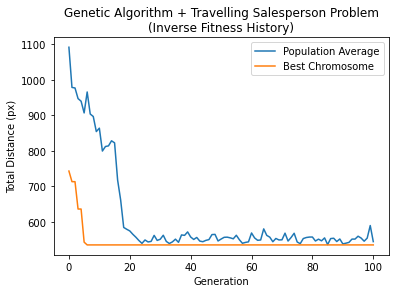

In [38]:
# Fitness History Plot

# --- Best Distance and Average Distance History
fig, dist_history = plt.subplots(1, 1, figsize=(6,4))

dist_history.plot(np.arange(generation_limit+1), ga.avg_dist_history, label="Population Average")
dist_history.plot(np.arange(generation_limit+1), ga.best_dist_history, label="Best Chromosome")

dist_history.set_title("Genetic Algorithm + Travelling Salesperson Problem\n(Inverse Fitness History)")
dist_history.set_xlabel('Generation')
dist_history.set_ylabel('Total Distance (px)')

dist_history.legend()

plt.show()

## A Closer Look at the Genetic Algorithm

### 1. Create Initial Population of Chromosomes

**Chromosomes**

In general, a population (or generation) consists of chromosomes (a.k.a solutions, or genotypes). Each chromosome encodes a solution. The actual characteristics of the chromosome manifests when it is 'expressed' in the context of some environment. Biologists call these characteristics the 'phenotype'.

In nature, the information that makes up any creature is encoded in a molecule called DNA. For example, some segment of a purple flower's DNA (the chromosome, or encoding) expresses a purple flower (the phenotype) in an environment where it can grow, like a field. The flower's particular phenotype, it's purple petal colour, is a solution to staying alive and reproducing because some petal colours attract pollinators better than others.

>More information on biological chomosomes [here](https://www.khanacademy.org/science/high-school-biology/hs-reproduction-and-cell-division/hs-chromosome-structure-and-numbers/a/dna-and-chromosomes-article)

**Chromosomes in the context of Genetic Algorithms (GA)**

A chromosome can be represented as an array:

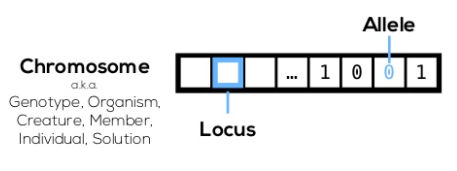

In [42]:
Image(filename='chromosomes_jeremy_fisher_2016.png')

>Image by [Jeremy Fisher (2016)](https://www.slideshare.net/JeremyFisher1/genetic-algorithms-programming-by-the-seat-of-your-genes)

'**Locus**' for biologists is the same as '**index**' for programmers. '**Allele**' is the particular value at some locus; this is the same as **array[index]** (i.e. the value of the array at the index) for programmers

---

In the travelling salesman problem, the chromosome is a NumPy array of integers. The phenotype of the array is the visitation order of the cities, where a city is represented by an integer.

For example, let's say we have cities 1, 2, 3. For a population size of 2, we could randomly initialize these chromosomes:

$$\text{Chromosome: } [1, 2, 3] \Rightarrow \text{Phenotype: Visit city 1 first, then city 2, then city 3}$$

$$\text{Chromosome: } [2, 3, 1] \Rightarrow \text{Phenotype: Visit city 2 first, then city 3, then city 1}$$

### 2. Calculate Fitness

To measure how 'good' a chromosome is, we need to assign it a fitness score. The fitness score determines how likely a chromosome will contribute it's alleles to the next generation of chromosomes. 

Going back to the flower example, the most fit flowers are more likely to reproduce. Let's say purple flowers attract bees better than the other colours. Consequently, purple flowers are more likely to be pollinated, reproduce, and pass on the purple phenotype to the next generation; we say that purple flowers have a high fitness relative to other flower colours. This means that over the generations, a greater proportion of the flowers will be purple. Biologists would say the purple phenotype will be selected for.

---

In TSP, the shorter the total distance of the trip, the better. In other words, we want to select for chromosomes with shorter phenotypes. So, our fitness function, $f$ is:

$$f(c) = \frac{1}{D_c}$$

where $f(c)$ is the fitness of some chromosome $c$, $D$ is phenotype, i.e. the total distance of $c$. Fitness functions are analogous to cost functions in other Machine Learning applications. 

>**Side Note**: I will use inverse fitness in the code because I find it more convenient to work with. Conceptually, this means I want the algorithm to select for the values with the lowest inverse fitness. Additionally, we can use non-linear fitness functions, like $f(c) = \frac{1}{(D_c)^2}$ and $f(c) = \frac{1}{(D_c)^4}$ to better maximize the likely of retaining fitter chromosomes in each generation.

### 3. Create the Next Generation

#### 3a. Parental Chromosome Selection

Evolution works by the process of selection. There must be some selection pressure from the environment on the chromosomes so that fitter chromosomes are more likely to survive than others.

In the case of elk, the individuals with the biggest and strongest antlers are more likely to win fights. There is a tournament of sorts between elk, where the winner gets to mate and pass on his genes. Over time, elk with bigger antlers will be selected for.

---

Similar to the elk scenario, let's randomly select pairs of chromosomes to compete with each other. The chromosome with the shorter phenotype will win the competition, and will be selected as a parental chromosome for the next generation. This is known as **tournament selection**. We will perform tournament selection twice to get two parental chromosomes. That way we can implement another useful idea from evolution, crossover, that I'll dicuss in the next section.

>Additionally, to make sure each subsequent generation has a chromosome that's at least as good as the last generation, we will automatically promote the $k$ fittest solutions into the next generation. This priniciple is called **elitism** because we are favouring the best (most elite) solutions. We will perform tournament selection with the remaining population.

#### 3.b Crossover

Children are clearly a mix of their mum and dad. This mixing of mum-ness and dad-ness happens at the level of biological chromosomes. Biologists call this chromosome-mixing process **crossover**. The biological [details](https://www.khanacademy.org/science/ap-biology/heredity/meiosis-and-genetic-diversity/a/phases-of-meiosis) aren't so important for our TSP algorithm, but for genetic algorithms, in general, the idea is to take two chromosomes and mix them up into new chromosomes. This can introduce into our population variations that are likely to lead to a global minima or maxima in the solution space.

In the literature on genetic algorithms, a common crossover technique is single-point crossover. This function takes two parental chromosomes and returns two offspring chromosomes that are a random mix of the two parental chromosomes. Unfortunately, we can't exactly use traditional genetic algorithm crossover functions in TSP. For example, take these two chromosomes:

$$[1, 8, 6, 4, 5, 3, 7, 2], [5, 2, 3, 8, 1, 7, 6, 4]$$

If we perform a single-point crossover, we might get

$$[1, 8, 6, 4,| 5, 3, 7, 2] \searrow [1, 8, 6, 4,| 1, 7, 6, 4]$$

$$[5, 2, 3, 8,| 1, 7, 6, 4] \nearrow [5, 2, 3, 8,| 5, 3, 7, 2]$$

But neither of these new chromosomes are valid paths because they miss some cities and repeat others.

According to the literature, **Partially Mapped Crossover (PMX)** is a crossover function that performs well for TSP (Larrañaga et al. 1999). The PMX function takes two parental chromosomes, designated $a$ and $b$, and performs the following:

1. Let offspring$_a$ = $a$, and offspring$_b$ = $b$
2. Randomly pick two loci
3. For each element $k_b$ in between the two loci in $b$: 
    1. Get the locus of $k_b$ in $a$ ($l_{ka}$) and $b$ ($l_{kb}$).
    2. In offspring$_a$, swap the alleles at $l_{ka}$ and $l_{kb}$
4. For each element $k_a$ in between the two loci in $a$: 
    1. Get the locus of $k_a$ in $a$ ($l_{ka}$) and $b$ ($l_{kb}$).
    2. In offspring$_b$, swap the alleles at $l_{ka}$ and $l_{kb}$

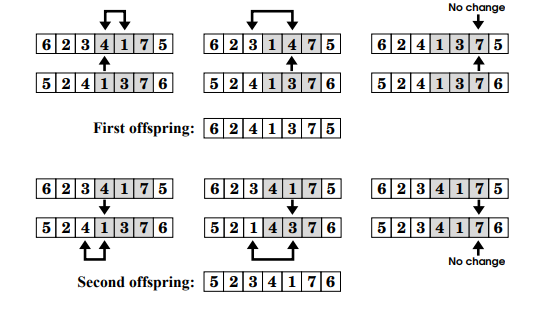

In [43]:
Image(filename='pmx_crossover_algorithm.png')

>Image by [Gokturk Ucoluk (2002)](https://user.ceng.metu.edu.tr/~ucoluk/research/publications/tspnew.pdf)

#### 3.c Mutation

In addition to the variation produced by crossover, another important function for obtaining novel solutions are **mutations**. In biological organisms, mutations are basically spelling mistakes at some locus in the chromosome. Most of the time these spelling mistakes have a neutral effect (like an eye colour mutation) or a detrimental effect (like a mutation that results in cancer). However, these mutations can sometimes be advantageous. For example, antibiotics kill most of the target bacteria, but some bacteria happen to have mutations that make them antibiotic-resistant.

---

We can apply a similar idea to the TSP. A common GA mutation function changes an allele at a random locus; this is called a point mutation function. As with crossover, we need to modify this traditional mutation function to obtain valid paths. For the TSP, we could use a mutation function that swaps the loci of two alleles instead. 

Let's use a mutation function called **Reverse Sequence Mutation (RSM)**. With some probability $p$ the chromosome will mutate. Mutating the chromosomes means we take the chromosome of length $N$, we choose two loci, $i$ and $j$, such that $1 \lt i \lt j \lt N$, then we reverse the order of every allele from $i$ through $j$, inclusive.

For example, let's say we pick $i=2$ and $j=5$. This means we reverse every allele from the 2nd locus to the 5th, inclusive. In the chromosome below, this means reversing the order of 2, 3, 4, 5:

$$RSM_{i=2, j=5} \bigg( [1, 2, 3, 4, 5, 6] \bigg) \Rightarrow [1, 5, 4, 3, 2, 6]$$

#### 4. Create Next Generation

This step is straightforward. We take the ideas we saw previously - chromosomes, fitnesses functions, tournament selection, elitism, crossover, mutations - and throw them in loop. The specific implementation can vary from problem to problem. I have written some pseudo code below

```python
def evolve(population):
    # --- Pick elite chromosomes from current population
    elites = pick_elite_chromosomes(population)
    # --- Initialize next generation with elite chromosomes
    next_generation = [elites]
    # --- Create tournament pool
    tournament_pool = population_without_elites(population, elites)
    while pop_size(next_generation) < pop_size(population):
        # --- Pick parent chromosomes
        parent_A = tournament_selection(remaining_population)
        parent_B = tournament_selection(remaining_population)
        # --- Crossover parents
        offspring_A, offspring_B = crossover(parent_A, parent_B)
        # --- Mutate offspring
        offspring_A = mutate(offspring_A)
        offspring_B = mutate(offspring_B)
        # --- Add offspring to next_generation
        next_generation += [offspring_A, offspring_B]
    return next_generation
```

We repeat this evolution for some number of generations until the algorithm produces a satisfactory solution.

>Please see the TSPGA class in the full jupyter notebook for more details, specifically the TSPGA class method ```evolve()``` 

## Conclusion

And that's it for the Genetic Algorithm! No calculus, or fancy linear algebra necessary for the algorithm to work. Just some basic functions and a lot of inspiration from Mother Nature.

To end off this notebook, below I have another demo of the Genetic Algorithm, but this time you can watch it solve a 20-city Travelling Salesperson Problem. See if you come up with a better solution!

## Genetic Algorithm Demo (20 cities)

In [83]:
# --- Initialize canvas
ga_canvas2 = Canvas(width=800, height=300)
display(ga_canvas2)

cities20 = create_cities(20, lower_bounds=[15, 15], upper_bounds=[(ga_canvas2.width//2)-15, (ga_canvas2.height)-15])

# --- Initialize GA Parameters
pop_size = 500
fitness_pow = 2
generation_limit20 = 300
crossover_func = pmx
mutation_func = rsmutation
ga20 = TSPGA(pop_size, cities20, fitness_pow, crossover_func, mutation_func)

# Other Animation Parameters
shifted_cities20 = np.copy(cities20)
shift = (ga_canvas2.width//2)
shifted_cities20[:, 0] += shift

# --- Animation Loop
draw_ga(ga_canvas2, ga20, cities20, shifted_cities20, 0)
for i in range(generation_limit20):
    ga20.evolve(num_elites=1, tournament_num=4, mutation_rate=1.0)
    draw_ga(ga_canvas2, ga20, cities20, shifted_cities20, i+1)

Canvas(height=300, width=800)

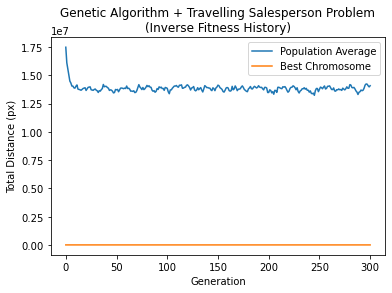

In [74]:
# Fitness History Plot

# --- Best Distance and Average Distance History
fig, dist_history = plt.subplots(1, 1, figsize=(6,4))

dist_history.plot(np.arange(generation_limit20+1), ga20.avg_dist_history, label="Population Average")
dist_history.plot(np.arange(generation_limit20+1), ga20.best_dist_history, label="Best Chromosome")

dist_history.set_title("Genetic Algorithm + Travelling Salesperson Problem\n(Inverse Fitness History)")
dist_history.set_xlabel('Generation')
dist_history.set_ylabel('Total Distance (px)')

dist_history.legend()

plt.show()

## References

Shiffman, D. (2017, May 1). Coding Challenge #35.4: Traveling Salesperson with Genetic Algorithm. YouTube. [https://www.youtube.com/watch?v=M3KTWnTrU_c](https://www.youtube.com/watch?v=M3KTWnTrU_c) 

CernerEng. (2016, July 11). Genetic Algorithms - Jeremy Fisher. YouTube. [https://youtu.be/7J-DfS52bnI](https://youtu.be/7J-DfS52bnI)
* Programming by the Seat of Your Genes [Slides](https://www.slideshare.net/JeremyFisher1/genetic-algorithms-programming-by-the-seat-of-your-genes) (Jeremy Fisher, 2016)

Larrañaga, P., Kuijpers, C. M. H., Murga, R. H., Inza, I., &amp; Dizdarevic, S. (1999). Genetic Algorithms for the Travelling Salesman Problem: A Review of Representations and Operators. Artificial Intelligence Review, 13(2), 129–170. [https://doi.org/10.1023/a:1006529012972](https://doi.org/10.1023/a:1006529012972) 

Üçoluk, G. (2002). Genetic Algorithm Solution of the TSP Avoiding Special Crossover and Mutation. Intelligent Automation &amp; Soft Computing, 8(3), 265–272. [https://doi.org/10.1080/10798587.2000.10642829](https://doi.org/10.1080/10798587.2000.10642829)

